# Zero-Shot Image Classification with Multimodal Models and FiftyOne

Traditionally, computer vision models are trained to predict a fixed set of categories. For image classification, for instance, many standard models are trained on the ImageNet dataset, which contains 1,000 categories. All images *must* be assigned to one of these 1,000 categories, and the model is trained to predict the correct category for each image.

For object detection, many popular models like YOLOv5, YOLOv8, and YOLO-NAS are trained on the MS COCO dataset, which contains 80 categories. In other words, the model is trained to detect objects in any of these categories, and ignore all other objects.

Thanks to the recent advances in multimodal models, it is now possible to perform zero-shot learning, which allows us to predict categories that were *not* seen during training. This can be especially useful when:

- We want to roughly pre-label images with a new set of categories
- Obtaining labeled data for all categories is impractical or impossible.
- The categories are changing over time, and we want to predict new categories without retraining the model.

In this walkthrough, you will learn how to apply and evaluate zero-shot image classification models to your data with FiftyOne, Hugging Face [Transformers](https://docs.voxel51.com/integrations/huggingface.html), and [OpenCLIP](https://docs.voxel51.com/integrations/openclip.html)!

It covers the following:

- Loading zero-shot image classification models from Hugging Face and OpenCLIP with the [FiftyOne Model Zoo](https://docs.voxel51.com/user_guide/model_zoo/index.html)
- Using the models to predict categories for images in your dataset
- Evaluating the predictions with FiftyOne

We are going to illustrate how to work with many multimodal models:

- [OpenAI CLIP](https://arxiv.org/abs/2103.00020)
- [AltCLIP](https://arxiv.org/abs/2211.06679v2)
- [ALIGN](https://arxiv.org/abs/2102.05918)
- [CLIPA](https://arxiv.org/abs/2305.07017)
- [SigLIP](https://arxiv.org/abs/2303.15343)
- [MetaCLIP](https://arxiv.org/abs/2309.16671)
- [EVA-CLIP](https://arxiv.org/abs/2303.15389v1)
- [Data Filtering Network (DFN)](https://arxiv.org/abs/2309.17425)

For a breakdown of what each model brings to the table, check out our [🕶️ comprehensive collection of Awesome CLIP Papers](https://github.com/jacobmarks/awesome-clip-papers?tab=readme-ov-file).

## Setup

For this walkthrough, we will use the [Caltech-256 dataset](https://docs.voxel51.com/user_guide/dataset_zoo/datasets.html#caltech-256), which contains 30,607 images across 257 categories. We will use 1000 randomly selected images from the dataset for demonstration purposes. The zero-shot models were not explicitly trained on the Caltech-256 dataset, so we will use this as a test of the models' zero-shot capabilities. Of course, you can use any dataset you like! 

💡 Your results may depend on how similar your dataset is to the training data of the zero-shot models.

Before we start, let's install the required packages:

```bash
pip install -U torch torchvision fiftyone transformers timm open_clip_torch
```

Now let's import the relevant modules and load the dataset:

In [3]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.brain as fob
from fiftyone import ViewField as F

In [6]:
dataset = foz.load_zoo_dataset(
    "caltech256", 
    max_samples=1000, 
    shuffle=True, 
    persistent=True
)
dataset.name = "CLIP-Comparison"

session = fo.launch_app(dataset)

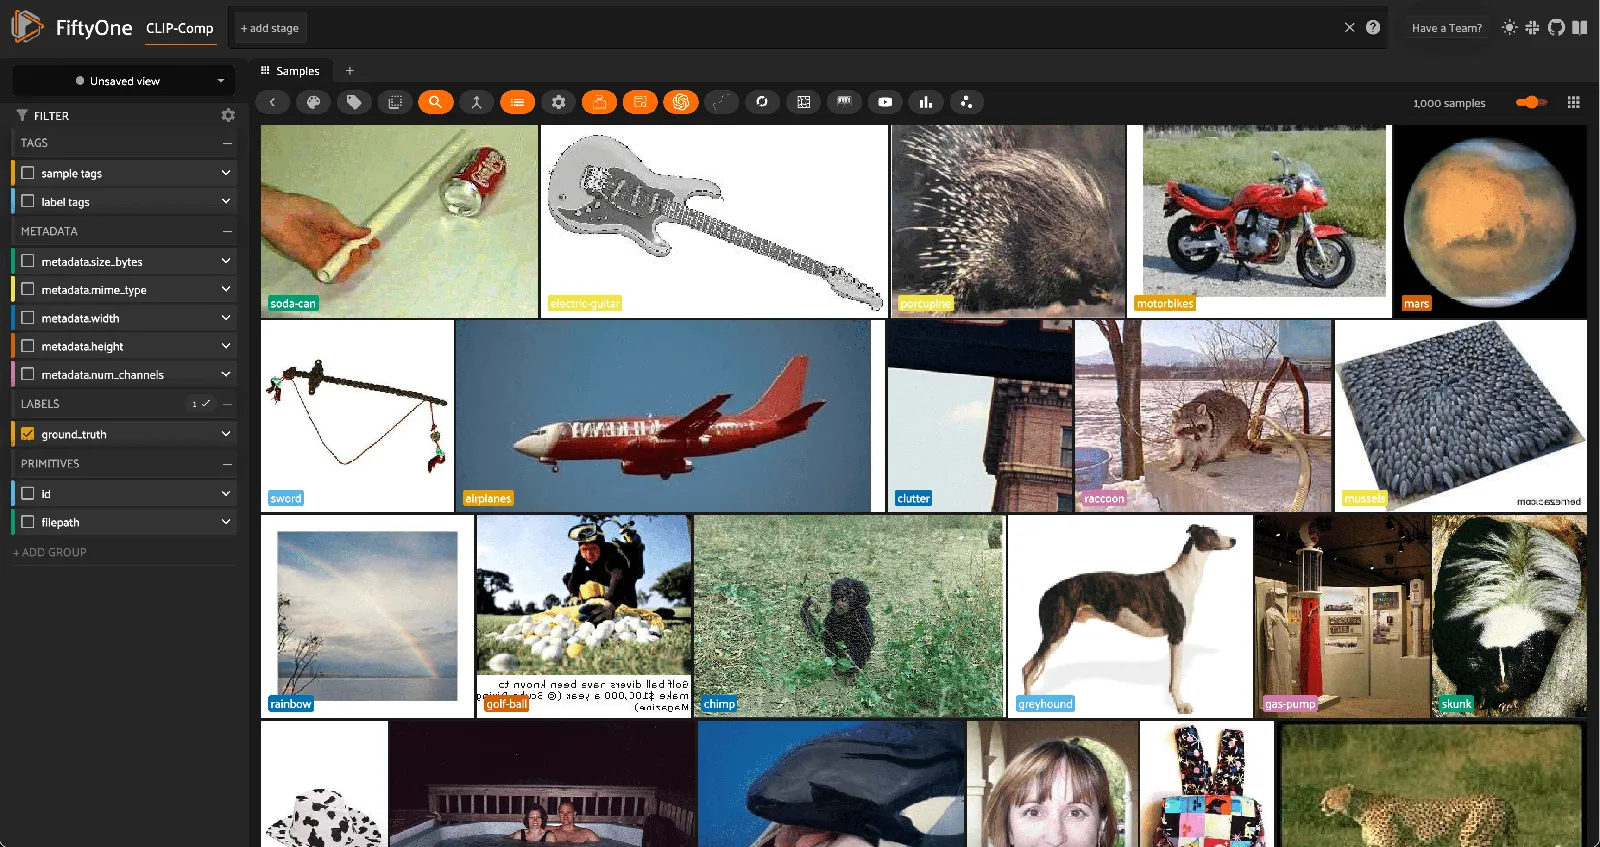

Here, we are using the `shuffle=True` option to randomly select 1000 images from the dataset, and are persisting the dataset to disk so that we can use it in future sessions. We also change the name of the dataset to reflect the experiment we are running.

Finally, let's use the dataset's `distinct()` method to get a list of the distinct categories in the dataset, which we will give to the zero-shot models to predict:

In [ ]:
classes = dataset.distinct("ground_truth.label")

## Zero-Shot Image Classification with the FiftyOne Zero-Shot Prediction Plugin

In a moment, we'll switch gears to a more explicit demonstration of how to load and apply zero-shot models in FiftyOne. This programmatic approach is useful for more advanced use cases, and illustrates how to use the models in a more flexible manner.

For simpler scenarios, check out the [FiftyOne Zero-Shot Prediction Plugin](https://github.com/jacobmarks/zero-shot-prediction-plugin), which provides a convenient graphical interface for applying zero-shot models to your dataset. The plugin supports all of the models we are going to use in this walkthrough, and is a great way to quickly experiment with zero-shot models in FiftyOne. In addition to classificaion, the plugin also supports zero-shot object detection, instance segmentation, and semantic segmentation.

If you have the [FiftyOne Plugin Utils Plugin](https://github.com/voxel51/fiftyone-plugins) installed, you can install the Zero-Shot Prediction Plugin from the FiftyOne App:

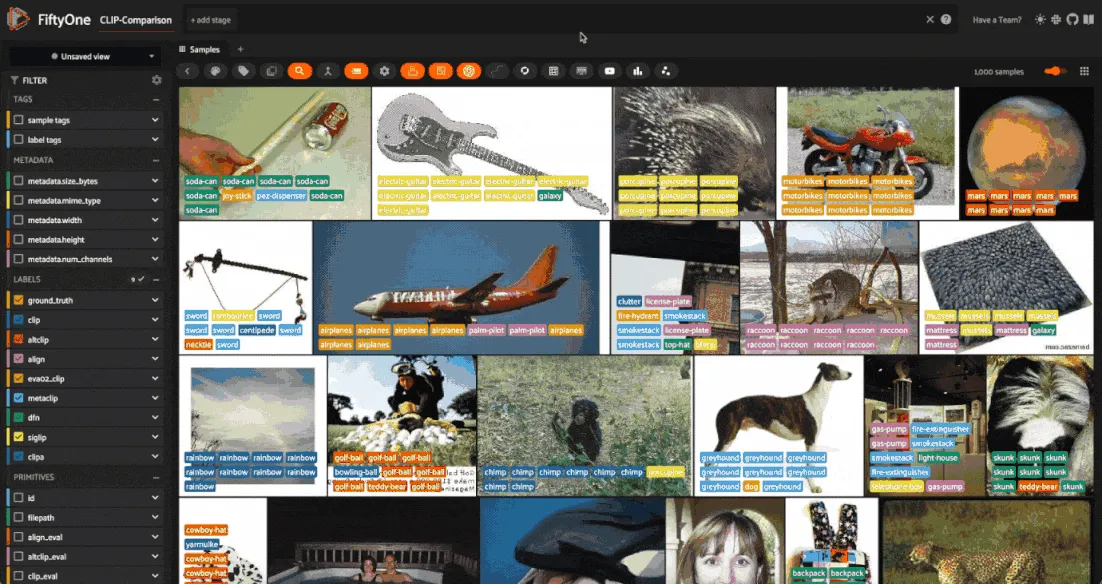

If not, you can install the plugin from the command line:

```bash
fiftyone plugins download https://github.com/jacobmarks/zero-shot-prediction-plugin
```

Once the plugin is installed, you can run zero-shot models from the FiftyOne App by pressing the backtick key ('\`') to open the command palette, selecting `zero-shot-predict` or `zero-shot-classify` from the dropdown, and following the prompts:

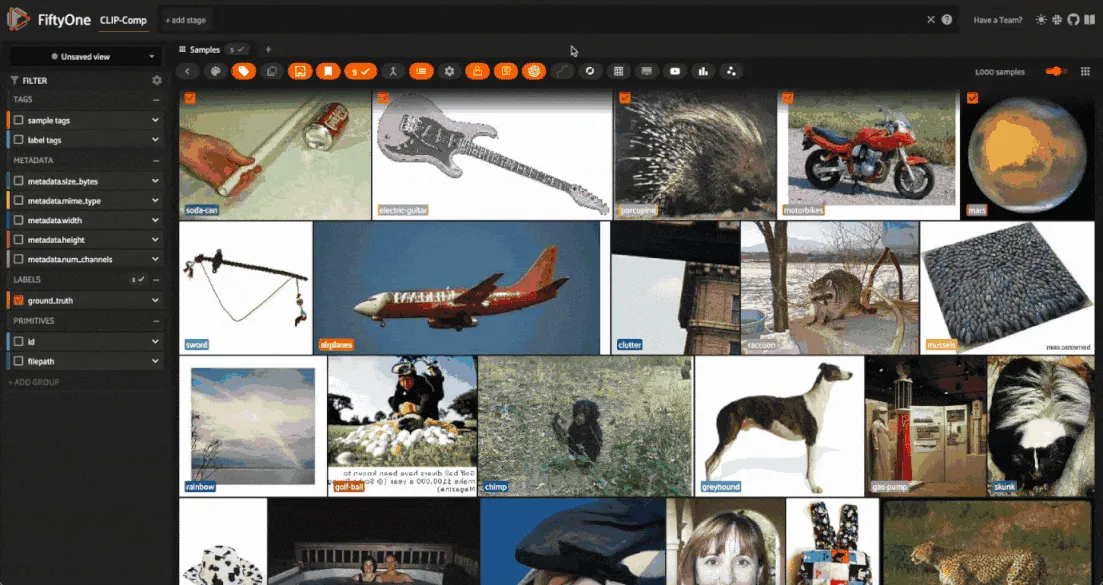

## Zero-Shot Image Classification with the FiftyOne Model Zoo

In this section, we will show how to explicitly load and apply a variety of zero-shot classification models to your dataset with FiftyOne. Our models will come from three places:

1. OpenAI's [CLIP](https://github.com/openai/CLIP) model, which is natively supported by FiftyOne
2. [OpenCLIP](https://github.com/mlfoundations/open_clip), which is a collection of open-source CLIP-style models
3. Hugging Face's [Transformers library](https://huggingface.co/docs/transformers/index), which provides a wide variety of zero-shot models

All of these models can be loaded from the FiftyOne Model Zoo via the `load_zoo_model()` function, although the arguments you pass to the function will depend on the model you are loading!

### Basic Recipe for Loading a Zero-Shot Model

Regardless of the model you are loading, the basic recipe for loading a zero-shot model is as follows:

```python
model = foz.load_zoo_model(
    "<zoo-model-name>",
    classes=classes,
    **kwargs
)
```

The zoo model name is the name under which the model is registered in the FiftyOne Model Zoo. 

- `"clip-vit-base32-torch"` specifies the natively supported CLIP model, CLIP-ViT-B/32
- `"open-clip-torch"` specifies that you want to load a specific model (architecture and pretrained checkpoint) from the OpenCLIP library. You can then specify the architecture with `clip_model="<clip-architecture>"` and the checkpoint with `pretrained="<checkpoint-name>"`. We will see examples of this in a moment. For a list of allowed architecture-checkpoint pairs, check out this [results table](https://github.com/mlfoundations/open_clip/blob/main/docs/openclip_results.csv) from the OpenCLIP documentation. The `name` column contains the value for `clip_model`.
- `"zero-shot-classification-transformer-torch"` specifies that you want to a zero-shot image classification model from the Hugging Face Transformers library. You can then specify the model via the `name_or_path` argument, which should be the repository name or model identifier of the model you want to load. Again, we will see examples of this in a moment.

💡 While we won't be exploring this degree of freedom, all of these models accept a `text_prompt` keyword argument, which allows you to override the prompt template used to embed the class names. Zero-shot classification results can vary based on this text!

Once we have our model loaded (and classes set), we can use it like any other image classification model in FiftyOne by calling the dataset's `apply_model()` method:


```python

dataset.apply_model(
    model,
    label_field="<where-to-store-predictions>",
)
```

For efficiency, we will also set our default batch size to 32, which will speed up the predictions:

In [12]:
fo.config.default_batch_size = 32

### Zero-Shot Image Classification with OpenAI CLIP

Starting off with the natively supported CLIP model, we can load and apply it to our dataset as follows:

In [ ]:
clip = foz.load_zoo_model(
    "clip-vit-base32-torch",
    classes=classes,
)

dataset.apply_model(clip, label_field="clip")

If we would like, after adding our predictions in the specified field, we can add some high-level information detailing what the field contains:

In [ ]:
field = dataset.get_field("clip")
field.description = "OpenAI CLIP predictions"
field.info = {"clip_model": "CLIP-ViT-B-32"}
field.save()

In [ ]:
session = fo.launch_app(dataset, auto=False)

To see the FiftyOne App, open a tab in your browser and navigate to `http://localhost:5151`!

We will then see this information when we hover over the "clip" field in the FiftyOne App. This can be useful if you want to use shorthand field names, or if you want to provide additional context to other users of the dataset.

For the rest of the tutorial, we will omit this step for brevity, but you can add this information to any field in your dataset!

### Zero-Shot Image Classification with OpenCLIP

To make life interesting, we will be running inference with 5 different OpenCLIP models:

- CLIPA
- Data Filtering Network (DFN)
- EVA-CLIP
- MetaCLIP
- SigLIP

To reduce the repetition, we're just going to create a dictionary for the `clip_model` and `pretrained` arguments, and then loop through the dictionary to load and apply the models to our dataset:

In [14]:
open_clip_args = {
    "clipa": {
        "clip_model": 'hf-hub:UCSC-VLAA/ViT-L-14-CLIPA-datacomp1B',
        "pretrained": '',
        },
    "dfn": {
        "clip_model": 'ViT-B-16',
        "pretrained": 'dfn2b',
        },
    "eva02_clip": {
        "clip_model": 'EVA02-B-16',
        "pretrained": 'merged2b_s8b_b131k',
        },
    "metaclip": {
        "clip_model": 'ViT-B-32-quickgelu',
        "pretrained": 'metaclip_400m',
        },
    "siglip": {
        "clip_model": 'hf-hub:timm/ViT-B-16-SigLIP',
        "pretrained": '',
        },
    }

In [ ]:
for name, args in open_clip_args.items():
    clip_model = args["clip_model"]
    pretrained = args["pretrained"]
    model = foz.load_zoo_model(
        "open-clip-torch",
        clip_model=clip_model,
        pretrained=pretrained,
        classes=classes,
    )

    dataset.apply_model(model, label_field=name)

### Zero-Shot Image Classification with Hugging Face Transformers

Finally, we will load and apply zero-shot image classification model sfrom the Hugging Face Transformers library. Once again, we will loop through a dictionary of model names and apply the models to our dataset:

In [15]:
transformer_model_repo_ids = {
    "altclip": "BAAI/AltCLIP",
    "align": "kakaobrain/align-base"
}

In [ ]:
for name, repo_id in transformer_model_repo_ids.items():
    model = foz.load_zoo_model(
        "zero-shot-classification-transformer-torch",
        name_or_path=repo_id,
        classes=classes,
    )

    dataset.apply_model(model, label_field=name)

## Evaluating Zero-Shot Image Classification Predictions with FiftyOne

### Using FiftyOne's Evaluation API

Now that we have applied all of our zero-shot models to our dataset, we can evaluate the predictions with FiftyOne! As a first step, let's use FiftyOne's [Evaluation API](https://docs.voxel51.com/user_guide/evaluation.html) to assign True/False labels to the predictions based on whether they match the ground truth labels.

First, we will use the dataset's schema to get a list of all of the fields that contain predictions:

In [23]:
classification_fields = sorted(list(
    dataset.get_field_schema(
        ftype=fo.EmbeddedDocumentField, embedded_doc_type=fo.Classification
    ).keys())
)

prediction_fields = [f for f in classification_fields if f != "ground_truth"]

Then, we will loop through these prediction fields and apply the dataset's `evaluate_classifications()` method to each one, evaluating against the `ground_truth` field:

In [ ]:
for pf in prediction_fields:
    eval_key = f"{pf}_eval"
    dataset.evaluate_classifications(
        pf,
        gt_field="ground_truth",
        eval_key=eval_key,
    )

We can then easily filter the dataset based on which models predicted the ground truth labels correctly, either programmatically in Python, or in the FiftyOne App. For example, here is how we could specify the view into the dataset containing all samples where SigLIP predicted the ground truth label correctly and CLIP did not:

In [16]:
dataset = fo.load_dataset("CLIP-Comparison")

In [17]:
siglip_not_clip_view = dataset.match((F("siglip_eval") == True) & (F("clip_eval") == False))

In [20]:
num_siglip_not_clip = len(siglip_not_clip_view)
print(f"There were {num_siglip_not_clip} samples where the SigLIP model predicted correctly and the CLIP model did not.")

There were 57 samples where the SigLIP model predicted correctly and the CLIP model did not.


Here is how we would accomplish the same thing in the FiftyOne App:

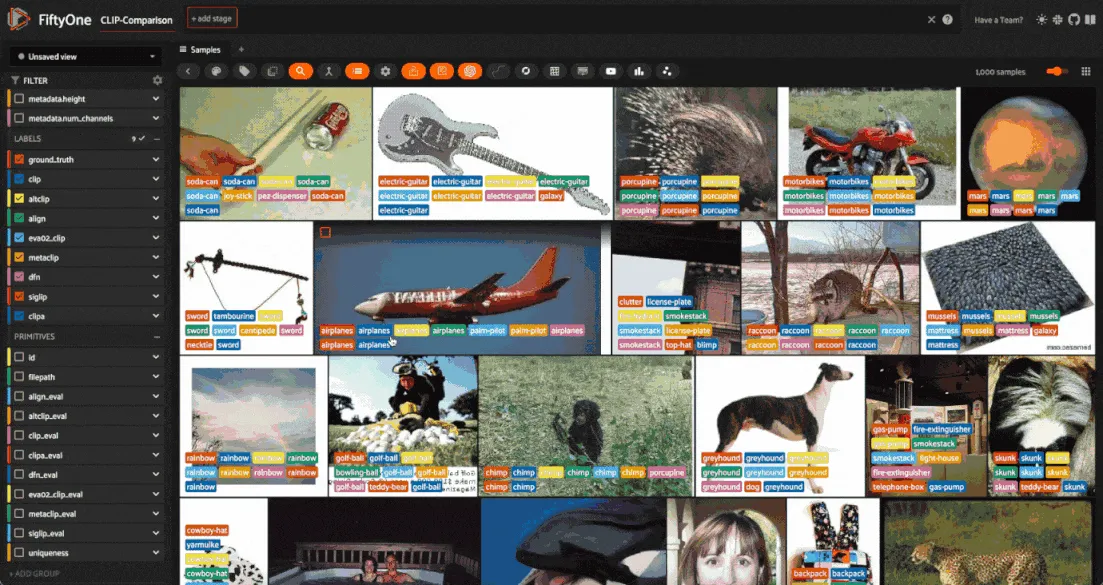

### High-Level Insights using Aggregations

With the predictions evaluated, we can use FiftyOne's [aggregation](https://docs.voxel51.com/user_guide/using_aggregations.html?highlight=aggregation) capabilities to get high-level insights into the performance of the zero-shot models.

This will allow us to answer questions like:

- Which model was "correct" most often?
- What models were most or least confident in their predictions?

For the first question, we can use the `count_values()` aggregation on the evaluation fields for our predictions, which will give us a count of the number of times each model was correct or incorrect. As an example:

In [22]:
dataset.count_values(f"clip_eval")

{False: 197, True: 803}

Looping over our prediction fields and turning these raw counts into percentages, we can get a high-level view of the performance of our models:

In [25]:
for pf in prediction_fields:
    eval_results = dataset.count_values(f"{pf}_eval")
    percent_correct = eval_results.get(True, 0) / sum(eval_results.values())
    print(f"{pf}:  {percent_correct:.1%} correct")

align:  83.7% correct
altclip:  87.6% correct
clip:  80.3% correct
clipa:  88.9% correct
dfn:  91.0% correct
eva02_clip:  85.6% correct
metaclip:  84.3% correct
siglip:  64.9% correct


At least on this dataset, it looks like the DFN model was the clear winner, with the highest percentage of correct predictions. The other strong performers were CLIPA and AltCLIP.

To answer the second question, we can use the `mean()` aggregation to get the average confidence of each model's predictions. This will give us a sense of how confident each model was in its predictions:

In [26]:
for pf in prediction_fields:
    mean_conf = dataset.mean(F(f"{pf}.confidence"))
    print(f"Mean confidence for {pf}: {mean_conf:.3f}")

Mean confidence for align: 0.774
Mean confidence for altclip: 0.883
Mean confidence for clip: 0.770
Mean confidence for clipa: 0.912
Mean confidence for dfn: 0.926
Mean confidence for eva02_clip: 0.843
Mean confidence for metaclip: 0.824
Mean confidence for siglip: 0.673


For the most part, mean model confidence seems pretty strongly correlated with model accuracy. The DFN model, which was the most accurate, also had the highest mean confidence!

### Advanced Insights using ViewExpressions

These high-level insights are useful, but as always, they only tell part of the story. To get a more nuanced understanding of the performance of our zero-shot models — and how the models interface with our data — we can use FiftyOne's [ViewExpressions](https://docs.voxel51.com/user_guide/using_views.html#filtering) to construct rich views of our data.

One thing we might want to see is where all of the models were correct or incorrect. To probe these questions, we can construct a list with one `ViewExpression` for each model, and then use the `any()` and `all()` methods:

In [27]:
exprs = [F(f"{pf}_eval") == True for pf in prediction_fields]

First, let's see how many samples every model got correct:

In [28]:
all_right_view = dataset.match(F().all(exprs))
print(f"{len(all_right_view)} samples were right for all models")

session = fo.launch_app(all_right_view, auto=False)

498 samples were right for all models
Session launched. Run `session.show()` to open the App in a cell output.


The fact that about half of the time, all of the models are "correct" and in agreement is good validation of both our data quality and the capabilities of our zero-shot models!

How about when all of the models are incorrect?

In [29]:
all_wrong_view = dataset.match(~F().any(exprs))
print(f"{len(all_wrong_view)} samples were wrong for all models")

session = fo.launch_app(all_wrong_view, auto=False)

45 samples were wrong for all models
Session launched. Run `session.show()` to open the App in a cell output.


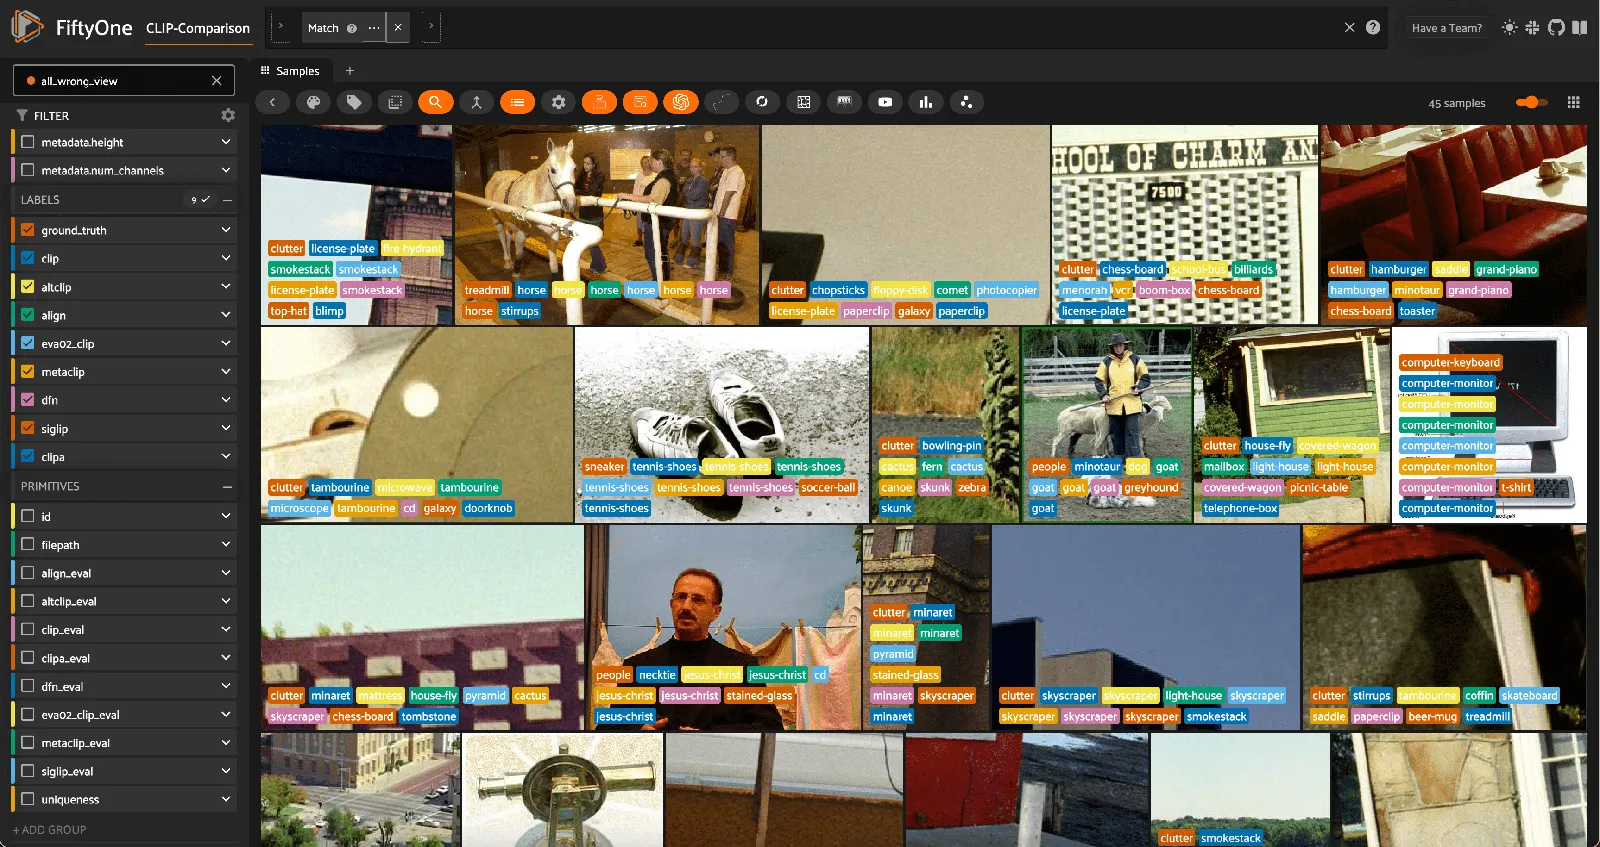

The samples where all of the models are supposedly incorrect are interesting and merit further investigation. It could be that the ground truth labels are incorrect, or that the images are ambiguous and difficult to classify. It could also be that the zero-shot models are not well-suited to the dataset, or that the models are not well-suited to the task. In any case, these samples are worth a closer look!

Looking at some of these samples in the FiftyOne App, we can see that some of the ground truth labels are indeed ambiguous or incorrect. Take the second image, for example. It is labeled as `"treadmill"`, while all but one of the zero-shot models predict `"horse"`. To a human, the image does indeed look like a horse, and the ground truth label is likely incorrect.

The seventh image is a prime example of ambiguity. The ground truth label is `"sneaker"`, but almost all of the zero-shot models predict `"tennis-shoes"`. It is difficult to say which label is correct, and it is likely that the ground truth label is not specific enough to be useful.

To get a more precise view into the relative quality of our zero-shot models, we would need to handle these edge cases and re-evaluate on the improved dataset. 

💡 This is a great example of how the combination of zero-shot models and FiftyOne can be used to iteratively improve the quality of your data and your models!

Before we wrap up, let's construct one even more nuanced view of our data: the samples where just *one* of the models was correct. This will really help us understand the strengths and weaknesses of each model.

To construct this view, we will copy the array of expressions, remove one model from the array, and see where that model was correct and the others were not. We will then loop through the models, and find the samples where each *any* of these conditions is met:

In [ ]:
n = len(prediction_fields)
sub_exprs = []
for i in range(n):
    tmp_exprs = exprs.copy()
    expr = tmp_exprs.pop(i)
    sub_exprs.append((expr & ~F().any(tmp_exprs)))

one_right_view = dataset.match(F().any(sub_exprs))

session = fo.launch_app(one_right_view, auto=False)

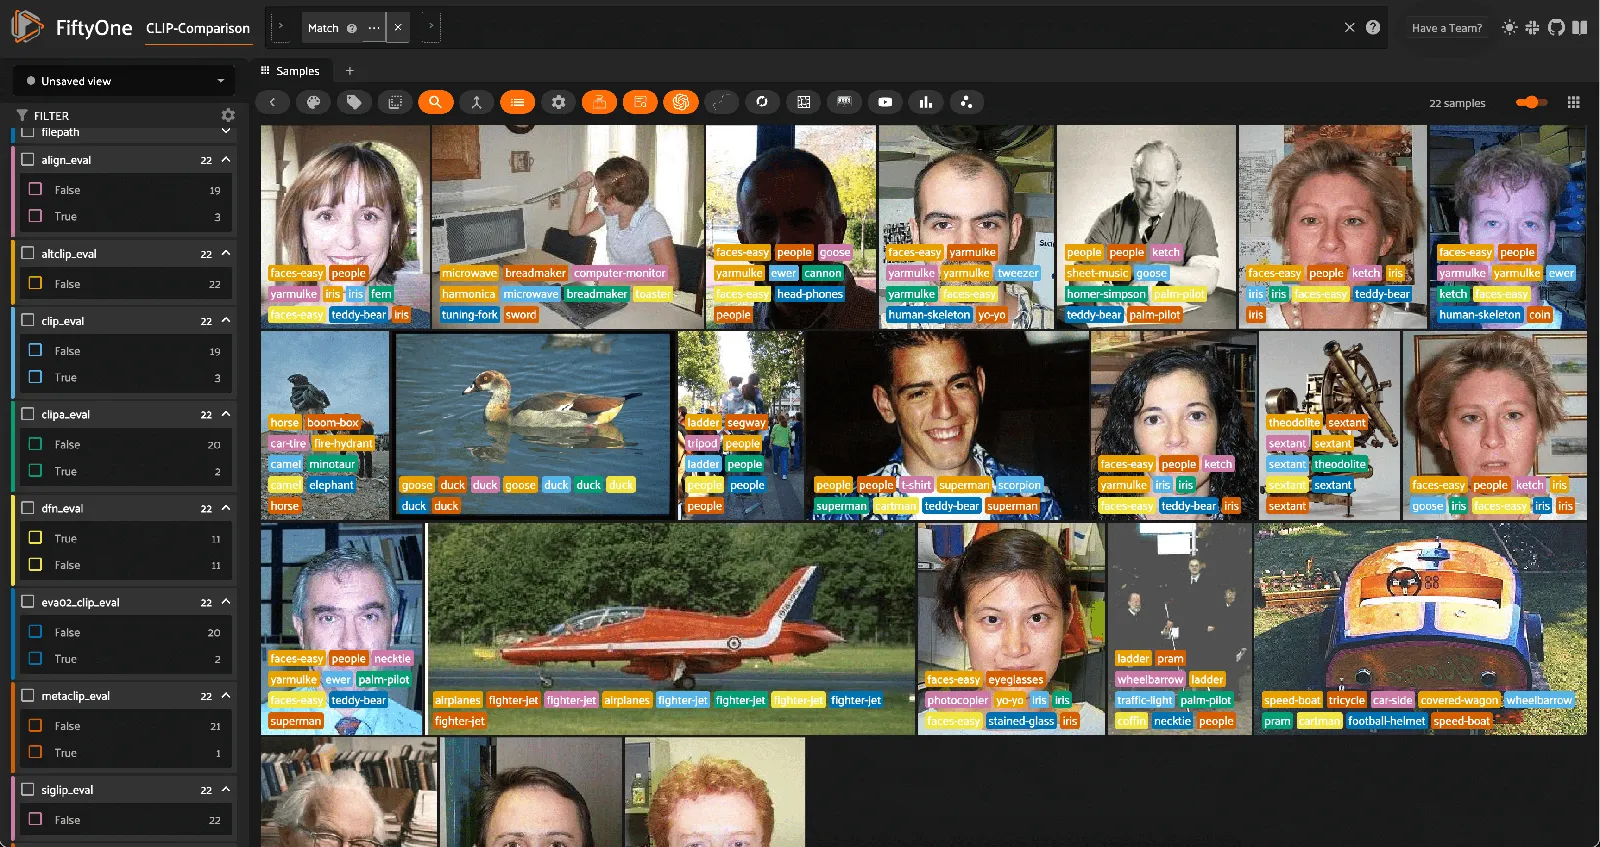

Looking at these samples in the FiftyOne App, a few things stand out:

- First, the vast majority of these samples are primarily images of people's faces. A lot of the "wrong" predictions are related to people, faces, or facial features, like `"eye-glasses"`, `"iris"`, `"yarmulke"`, and `"human-skeleton"`. This is a good reminder that zero-shot models are not perfect, and that they are not well-suited to all types of images.

- Second, of all 22 samples where only one model was correct, 11 of them were correctly predicted by the DFN model. This is more validation of the DFN model's strong performance on this dataset.

## Summary

Zero-shot image classification is a powerful tool for predicting categories that were not seen during training. But it is not a panacea, and it is important to understand the strengths and weaknesses of zero-shot models, and how they interface with your data.

In this walkthrough, we showed how to not only apply a variety of zero-shot image classification models to your data, but also how to evaluate them and choose the best model for your use case.

The same principles can be applied to other types of zero-shot models, like zero-shot object detection, instance segmentation, and semantic segmentation. If you're interested in these use cases, check out the [FiftyOne Zero-Shot Prediction Plugin](https://github.com/jacobmarks/zero-shot-prediction-plugin).

For zero-shot object detection, here are some resources to get you started:

- [YOLO-World](https://docs.voxel51.com/integrations/ultralytics.html#open-vocabulary-detection) from Ultralytics
- [Zero-Shot Detection Transformers](https://docs.voxel51.com/integrations/huggingface.html#zero-shot-object-detection) from Hugging Face
- [Evaluating Object Detections](https://docs.voxel51.com/tutorials/evaluate_detections.html) tutorial

